# Check for GPU availability
This code checks if a GPU is available and prints the GPU's name if it is. Otherwise, it prints a message indicating that no GPU is available and the CPU will be used instead.

In [1]:
import torch

# Check for GPU availability
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using GPU: NVIDIA GeForce RTX 3080


# Setting up the dataset 
It downloads and sets up a directory 'data' the first time this cell is executed

Total number of training images: 60000
Total number of testing images: 10000
Total number of training images in subset: 60000
Total number of testing images in subset: 10000
Training data range: min = 0.0, max = 1.0
Testing data range: min = 0.0, max = 1.0


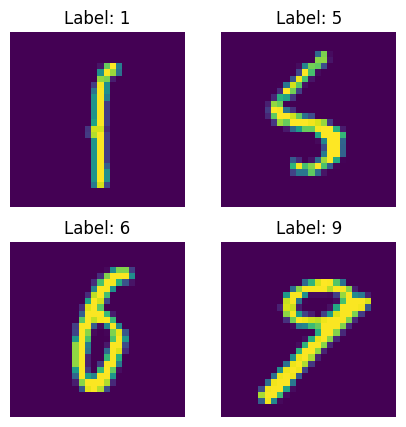

In [14]:
from mnist_loader import load_mnist, plot_sample_images

# Load the MNIST dataset
train_loader, test_loader = load_mnist(num_samples_train=60000, num_samples_test=10000, batch_size=64)  

# Plot sample images
plot_sample_images(train_loader)

In [3]:
from enhanced_vae_model import EnhancedVAE, loss_function, init_model

# Initialize the model and optimizer
model, optimizer = init_model(latent_dim=10, device=device)

In [4]:
def load_model(model, path):
    # Check if CUDA is available
    if torch.cuda.is_available():
        # Load the model weights to GPU
        state_dict = torch.load(path)
    else:
        # Load the model weights to CPU
        state_dict = torch.load(path, map_location=torch.device('cpu'))
    
    # Load the state dict into the model
    model.load_state_dict(state_dict)
    
    # Set the model to evaluation mode
    model.eval()
    
    return model

# Example usage
model_path = 'vae_model_gauss_enh10.pth'
try:
    model = load_model(model, model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")

Model loaded successfully.


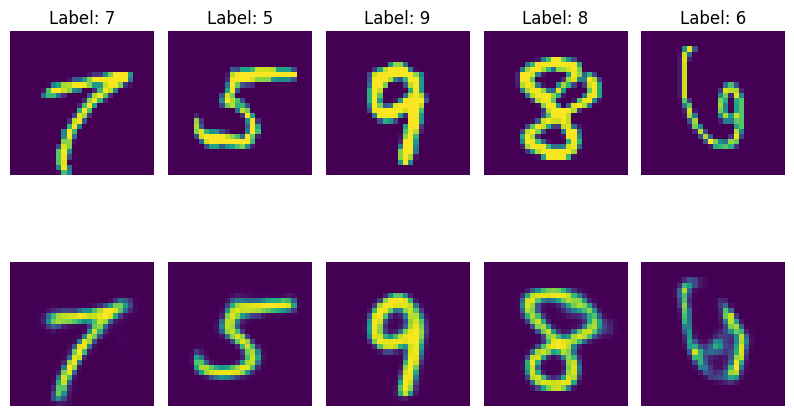

In [5]:
import random
import matplotlib.pyplot as plt

# Function to visualize results
def visualize_results(model, data_loader, num_images=10):
    model.eval()
    with torch.no_grad():
        for data, labels in data_loader:
            data = data.to(device)
            recon, _, _ = model(data)
            break

    # Randomly select num_images indices
    indices = random.sample(range(len(data)), num_images)

    # Display original and reconstructed images with labels
    plt.figure(figsize=(2 * num_images, 6))
    for i, idx in enumerate(indices):
        # Original
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(data[idx].cpu().numpy().reshape(28, 28), cmap='viridis')
        plt.title(f'Label: {labels[idx].item()}')
        plt.xlabel('Original')
        plt.axis('off')

        # Reconstructed
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(recon[idx].cpu().numpy().reshape(28, 28), cmap='viridis')
        plt.xlabel('Reconstructed')
        plt.axis('off')

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.show()

# Example usage with variable number of images
num_images_to_display = 5
visualize_results(model, test_loader, num_images=num_images_to_display)


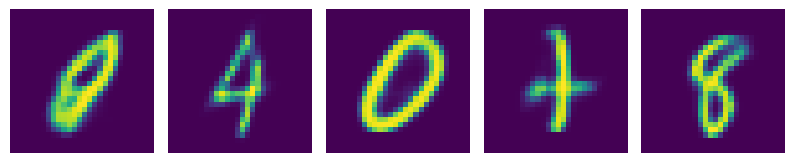

In [6]:
# Function to generate and visualize random numbers
def generate_random_numbers(model, num_samples=10):
    latent_dim_size = model.get_latent_dim()  # Get latent_dim_size from the model
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim_size).to(next(model.parameters()).device)  # Sample from a standard normal distribution
        samples = model.decode(z).cpu()
    plt.figure(figsize=(2 * num_samples, 4))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(samples[i].numpy().reshape(28, 28), cmap='viridis')
        plt.axis('off')
    
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.show()

# Generate and visualize random numbers
generate_random_numbers(model, num_samples=5)

In [7]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def extract_latent_activations(model, data_loader):
    device = next(model.parameters()).device  # Get the device from the model
    latent_dim = model.get_latent_dim()  # Get the latent dimension from the model
    model.eval()
    activations = []
    with torch.no_grad():
        for data, labels in tqdm(data_loader, desc="Extracting latent activations"):
            data = data.to(device)
            mu, logvar = model.encode(data)
            latent_space = model.reparameterize(mu, logvar)
            
            for i in range(len(labels)):
                digit = labels[i].item()
                latent_rep = latent_space[i].cpu().numpy()
                
                # Add overall latent representation
                activation_dict = {
                    'Digit': digit,
                    'Latent Representation': latent_rep
                }
                
                # Add individual neuron activations
                for j, activation in enumerate(latent_rep):
                    activation_dict[f'Latent Neuron {j}'] = j
                    activation_dict[f'Activation {j}'] = activation
                
                activations.append(activation_dict)
    
    return pd.DataFrame(activations)

# Extract latent activations
df = extract_latent_activations(model, test_loader)

# Display the first few rows of the DataFrame
display(df.head())

# Basic statistics of the activations
display(df.describe())

# You might want to save this DataFrame for further analysis
# df.to_csv('latent_activations.csv', index=False)

Extracting latent activations:   0%|          | 0/157 [00:00<?, ?it/s]

,Digit,Latent Representation,Latent Neuron 0,Activation 0,Latent Neuron 1,Activation 1,Latent Neuron 2,Activation 2,Latent Neuron 3,Activation 3,...,Latent Neuron 5,Activation 5,Latent Neuron 6,Activation 6,Latent Neuron 7,Activation 7,Latent Neuron 8,Activation 8,Latent Neuron 9,Activation 9
0,5,"[-0.8038223, -0.31138617, 0.62689817, 0.631705...",0,-0.803822,1,-0.311386,2,0.626898,3,0.631705,...,5,1.266338,6,1.628292,7,-0.938821,8,-0.475304,9,1.485971
1,8,"[-0.98302305, 0.059580415, 0.42284167, -0.4425...",0,-0.983023,1,0.059580,2,0.422842,3,-0.442598,...,5,-1.693891,6,0.168363,7,-0.987000,8,-1.779032,9,-0.577646
2,3,"[1.5315099, -0.90178, -0.040605612, 0.05728940...",0,1.531510,1,-0.901780,2,-0.040606,3,0.057289,...,5,0.734373,6,0.940884,7,0.090159,8,-1.277676,9,-0.368908
3,1,"[1.0634823, -1.7153201, 0.252477, 1.5995537, -...",0,1.063482,1,-1.715320,2,0.252477,3,1.599554,...,5,-1.190982,6,0.557788,7,1.020116,8,-0.333864,9,-0.597126
4,8,"[-1.0415874, 1.604817, -0.17876509, -0.0190374...",0,-1.041587,1,1.604817,2,-0.178765,3,-0.019037,...,5,-0.589575,6,0.409221,7,1.518074,8,0.154918,9,-0.853129


,Digit,Latent Neuron 0,Activation 0,Latent Neuron 1,Activation 1,Latent Neuron 2,Activation 2,Latent Neuron 3,Activation 3,Latent Neuron 4,...,Latent Neuron 5,Activation 5,Latent Neuron 6,Activation 6,Latent Neuron 7,Activation 7,Latent Neuron 8,Activation 8,Latent Neuron 9,Activation 9
count,10000.000000,10000.0,10000.000000,10000.0,10000.000000,10000.0,10000.000000,10000.0,10000.000000,10000.0,...,10000.0,10000.000000,10000.0,10000.000000,10000.0,10000.000000,10000.0,10000.000000,10000.0,10000.000000
mean,4.443400,0.0,-0.005225,1.0,-0.097775,2.0,-0.059658,3.0,-0.024344,4.0,...,5.0,0.032658,6.0,0.029505,7.0,0.026551,8.0,-0.004897,9.0,-0.047074
std,2.895865,0.0,1.011289,0.0,1.009009,0.0,1.027899,0.0,1.000449,0.0,...,0.0,1.009820,0.0,1.016512,0.0,0.974265,0.0,1.046734,0.0,1.003127
min,0.000000,0.0,-4.416899,1.0,-4.539969,2.0,-3.526025,3.0,-3.976785,4.0,...,5.0,-3.346983,6.0,-3.336331,7.0,-4.254313,8.0,-3.657804,9.0,-4.038256
25%,2.000000,0.0,-0.681329,1.0,-0.797842,2.0,-0.763202,3.0,-0.676915,4.0,...,5.0,-0.657644,6.0,-0.704944,7.0,-0.615440,8.0,-0.760325,9.0,-0.712735
50%,4.000000,0.0,0.018220,1.0,-0.082822,2.0,-0.049877,3.0,-0.066419,4.0,...,5.0,0.020383,6.0,0.028728,7.0,0.029842,8.0,-0.047565,9.0,-0.065252
75%,7.000000,0.0,0.677007,1.0,0.609134,2.0,0.628642,3.0,0.567230,4.0,...,5.0,0.726965,6.0,0.763319,7.0,0.670763,8.0,0.715071,9.0,0.595487
max,9.000000,0.0,4.049270,1.0,4.110087,2.0,3.149997,3.0,2.806744,4.0,...,5.0,4.063869,6.0,3.971364,7.0,3.886727,8.0,3.849842,9.0,3.921071


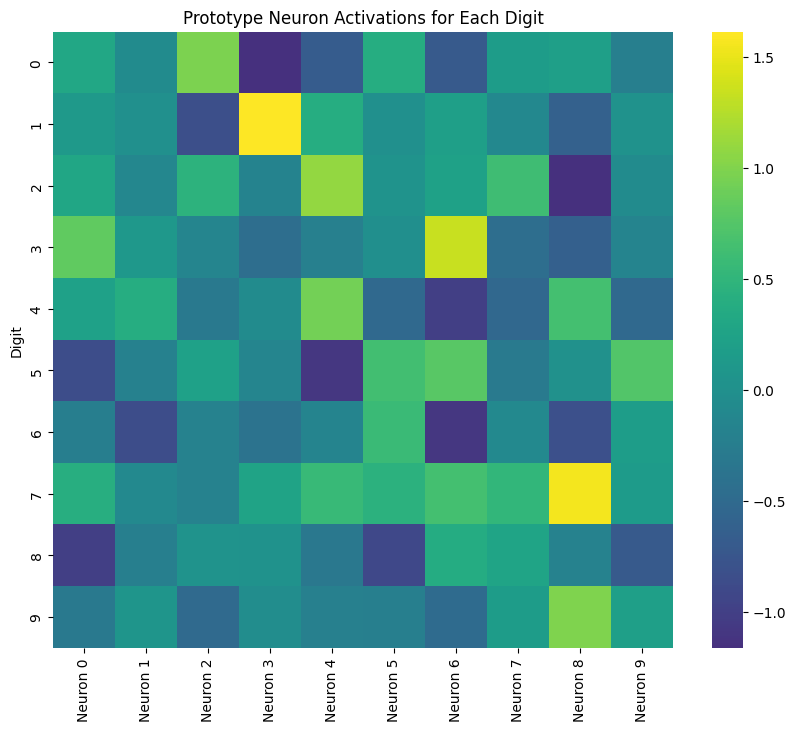

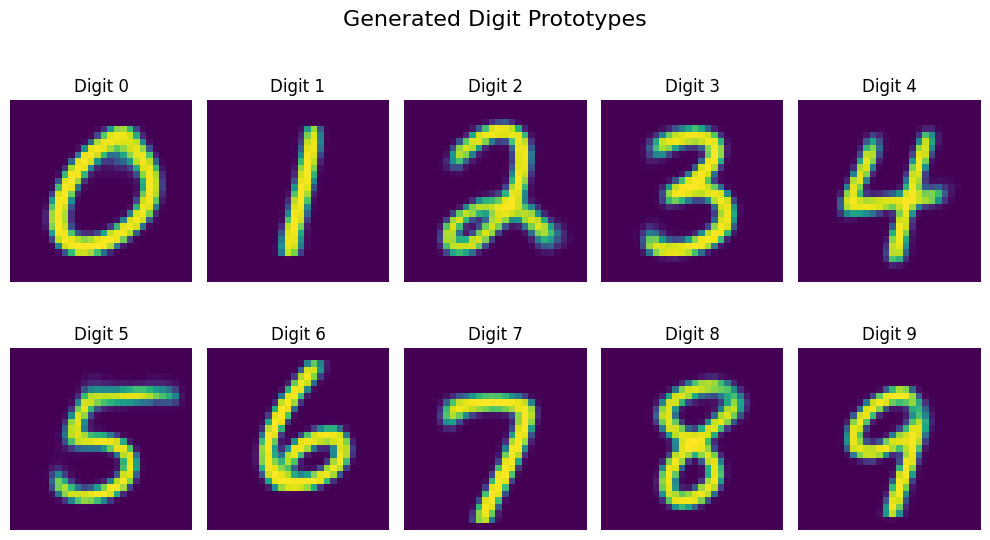

Digit 0:
neuron_values = {
    0: 0.311036,
    1: -0.059549,
    2: 0.970337,
    3: -1.162045,
    4: -0.684478,
    5: 0.383859,
    6: -0.712478,
    7: 0.151870,
    8: 0.198008,
    9: -0.240154,
}

Digit 1:
neuron_values = {
    0: 0.120572,
    1: -0.012696,
    2: -0.829255,
    3: 1.612656,
    4: 0.387573,
    5: -0.009986,
    6: 0.203030,
    7: -0.105949,
    8: -0.611819,
    9: 0.021974,
}

Digit 2:
neuron_values = {
    0: 0.297518,
    1: -0.114687,
    2: 0.454113,
    3: -0.172149,
    4: 1.089982,
    5: 0.043106,
    6: 0.227926,
    7: 0.611638,
    8: -1.151905,
    9: -0.069262,
}

Digit 3:
neuron_values = {
    0: 0.830335,
    1: 0.109020,
    2: -0.149526,
    3: -0.447668,
    4: -0.216279,
    5: -0.017311,
    6: 1.332947,
    7: -0.459686,
    8: -0.633705,
    9: -0.158210,
}

Digit 4:
neuron_values = {
    0: 0.221632,
    1: 0.378673,
    2: -0.300601,
    3: -0.060680,
    4: 0.920736,
    5: -0.522402,
    6: -1.000908,
    7: -0.532608,
    8: 0.65

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
import numpy as np

def calculate_digit_prototypes(df):
    # Extract the activation columns
    activation_columns = [col for col in df.columns if col.startswith('Activation')]
    
    # Compute average activations per neuron per digit
    prototypes = df.groupby('Digit')[activation_columns].mean()
    
    # Rename columns to match the original format
    prototypes.columns = [f'Neuron {i}' for i in range(len(activation_columns))]
    
    return prototypes

def generate_prototype_images(model, prototypes):
    device = next(model.parameters()).device  # Get the device from the model
    model.eval()
    with torch.no_grad():
        # Convert prototypes to tensor
        prototype_tensors = torch.tensor(prototypes.values, dtype=torch.float32).to(device)
        
        # Generate images
        generated_images = model.decode(prototype_tensors).cpu().numpy()
        
        # Plot the generated images
        fig, axes = plt.subplots(2, 5, figsize=(10, 6))
        for i, ax in enumerate(axes.flat):
            ax.imshow(generated_images[i].reshape(28, 28), cmap='viridis')
            ax.set_title(f"Digit {i}")
            ax.axis('off')
        
        plt.suptitle("Generated Digit Prototypes", fontsize=16)
        plt.tight_layout()
        plt.show()

# Calculate prototypes
prototypes = calculate_digit_prototypes(df)

# Display the prototypes as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(prototypes, cmap='viridis', center=0, annot=False, fmt='.2f')
plt.title('Prototype Neuron Activations for Each Digit')
plt.ylabel('Digit')
plt.show()

# Generate and display prototype images
generate_prototype_images(model, prototypes)

# Print the prototype values for each digit in the specified format
for digit in range(10):
    print(f"Digit {digit}:")
    print(f"neuron_values = {{")
    for neuron_index, (neuron, value) in enumerate(prototypes.loc[digit].items()):
        print(f"    {neuron_index}: {value:.6f},")
    print("}\n")

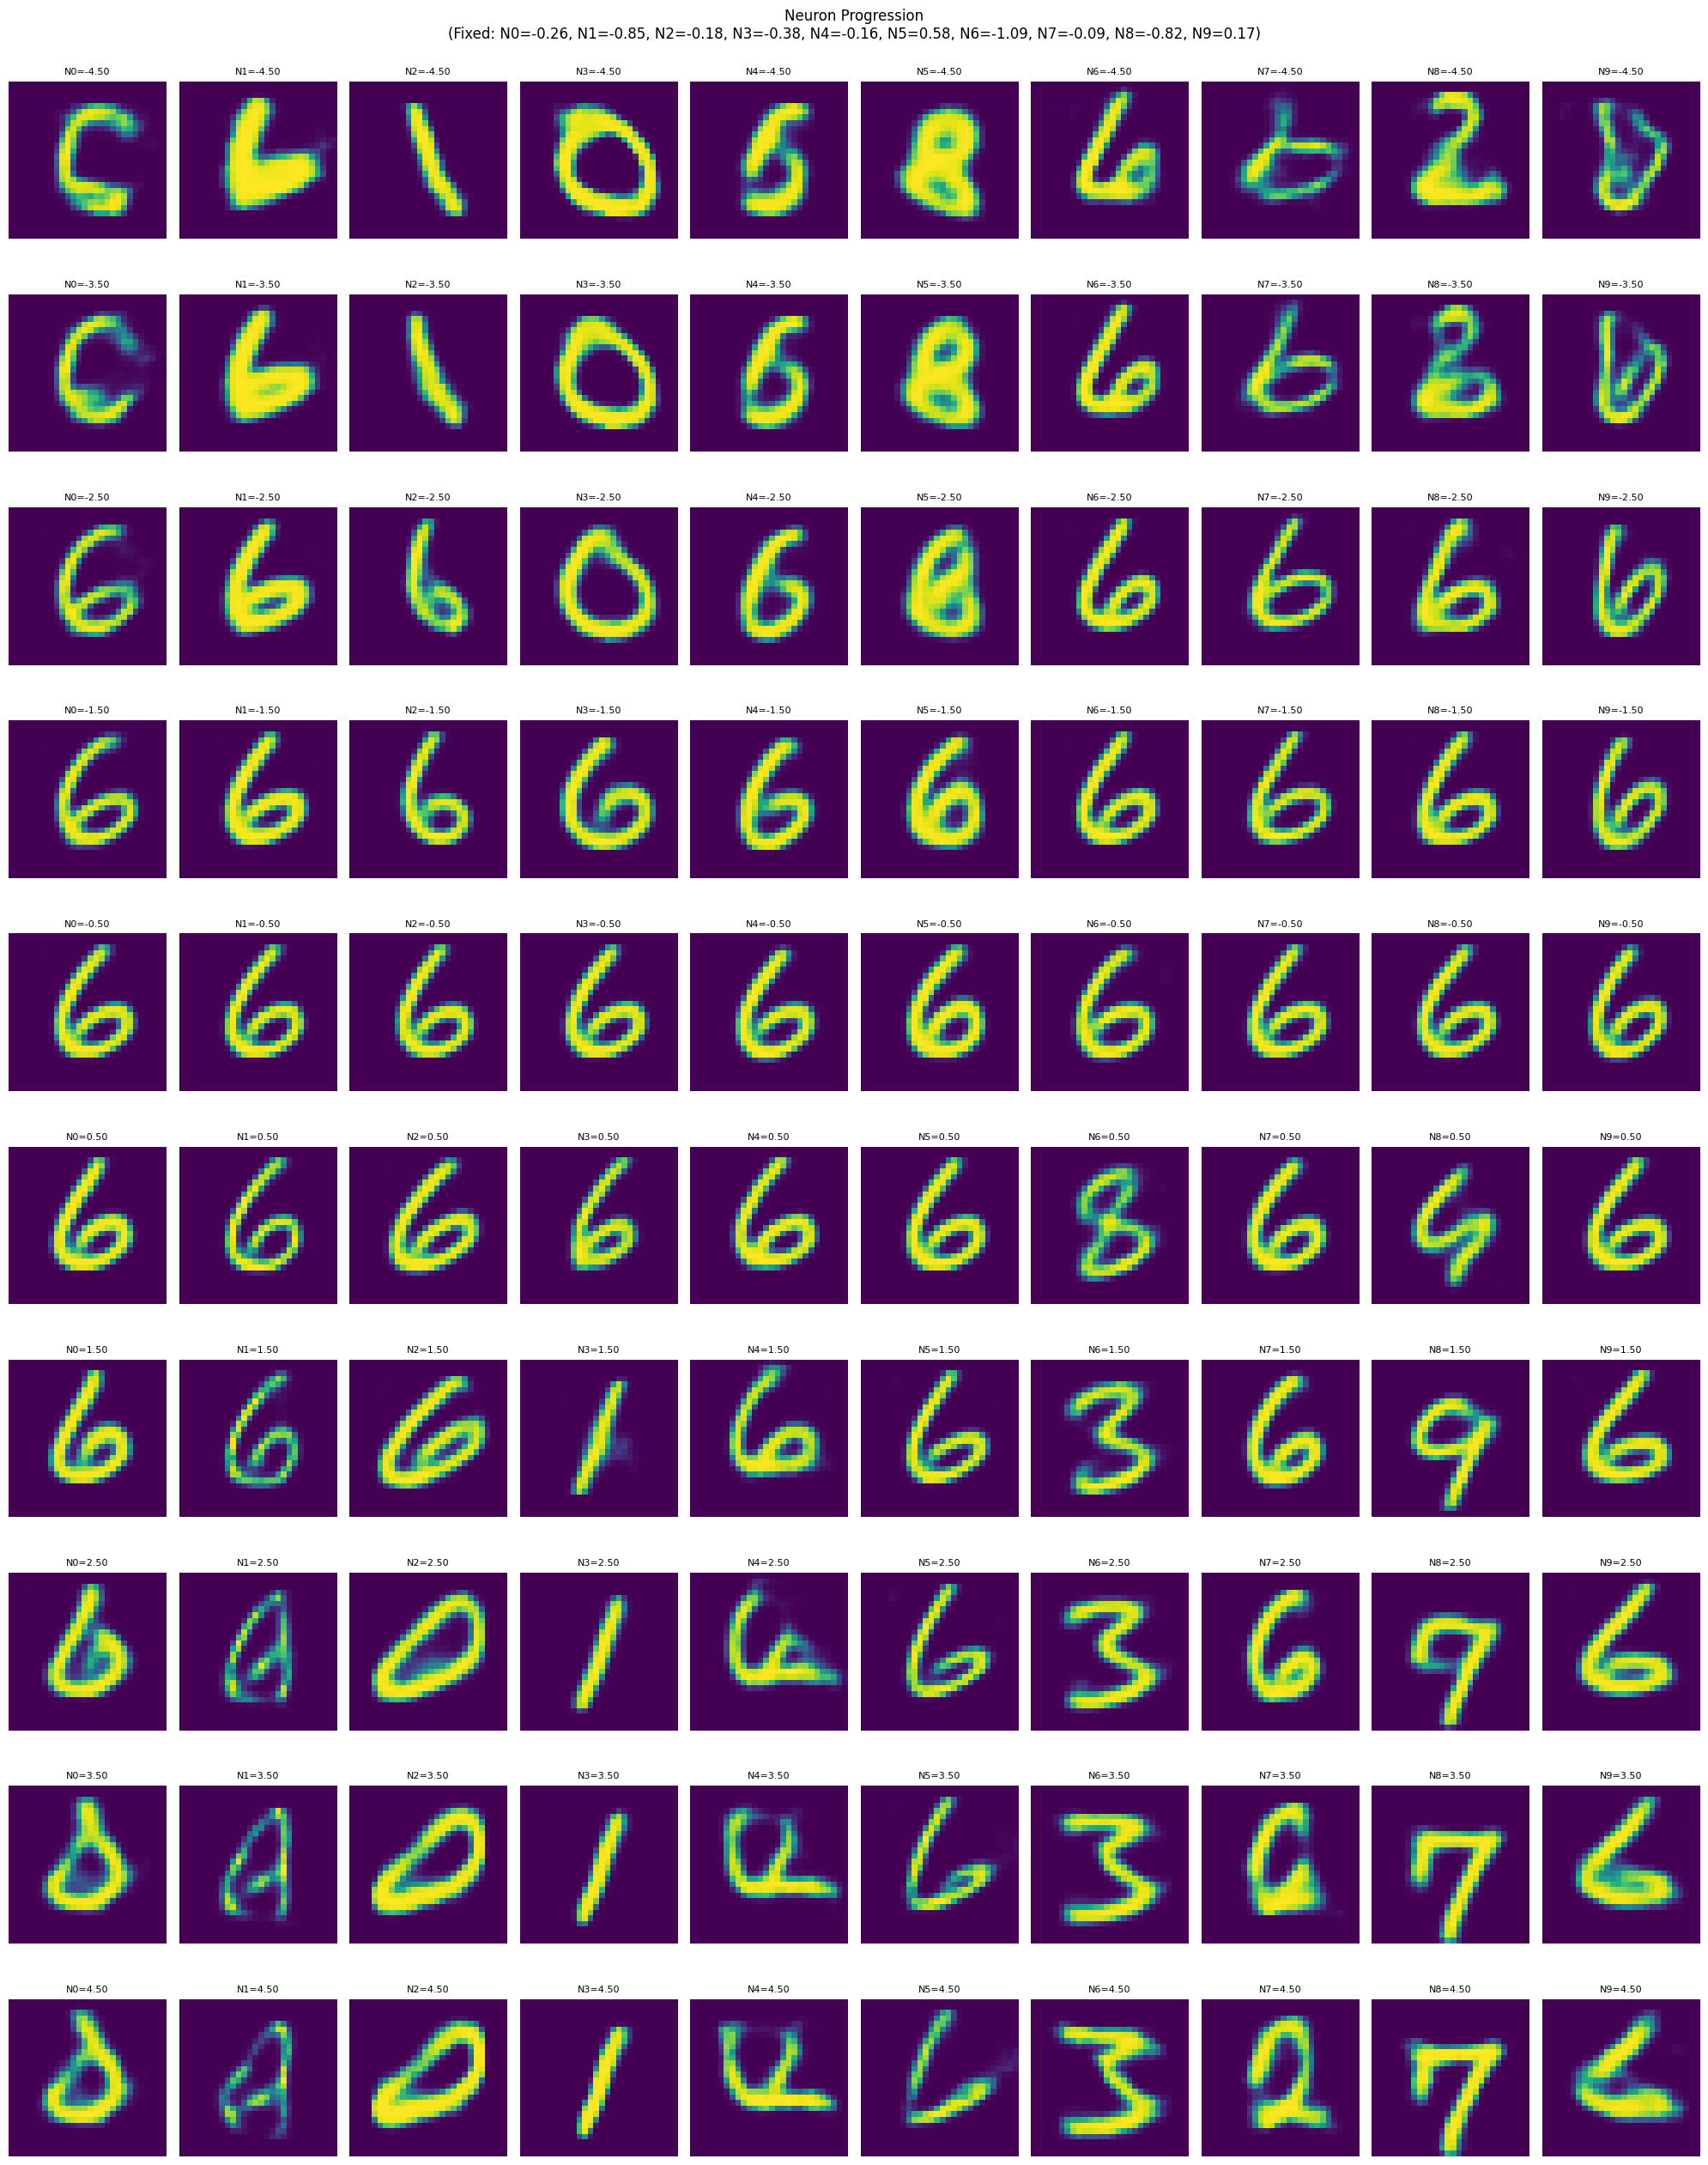

In [9]:
import matplotlib.pyplot as plt
import torch
from torch.distributions import Normal

def generate_images_with_neuron_progression(model, neurons_to_iterate, neuron_values, num_images=16, steps=11, start_value=-2, end_value=2):
    device = next(model.parameters()).device  # Get the device from the model
    model.eval()
    with torch.no_grad():
        dist = Normal(0, 1)
        
        if neurons_to_iterate is all:
            neurons_to_iterate = list(neuron_values.keys())
        elif not isinstance(neurons_to_iterate, list):
            neurons_to_iterate = [neurons_to_iterate]
        
        num_neurons = len(neurons_to_iterate)
        fig, axes = plt.subplots(steps, num_neurons, figsize=(num_neurons*2, steps*2.5))  # Increased figure height
        
        # Ensure axes is always a 2D array
        if num_neurons == 1:
            axes = axes[:, None]
        
        for step in range(steps):
            z = dist.sample((num_images, model.get_latent_dim())).to(device)
            
            for neuron, value in neuron_values.items():
                z[:, neuron] = value
            
            iterated_value = start_value + (end_value - start_value) * step / (steps - 1)
            
            for col, neuron_to_iterate in enumerate(neurons_to_iterate):
                z_neuron = z.clone()
                z_neuron[:, neuron_to_iterate] = iterated_value
                
                generated_images = model.decode(z_neuron).cpu()
                
                ax = axes[step, col]
                ax.imshow(generated_images[0].squeeze(), cmap='viridis')
                ax.axis('off')
                ax.set_title(f"N{neuron_to_iterate}={iterated_value:.2f}", fontsize=8)  # Reduced font size
        
        manipulated_info = ", ".join([f"N{n}={v:.2f}" for n, v in neuron_values.items()])
        plt.suptitle(f"Neuron Progression\n(Fixed: {manipulated_info})", fontsize=12, y=1.02)  # Added line break and adjusted y position
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.999)  # Adjust top margin
        plt.show()

# Example usage:
neuron_values = {
    0: -0.258041,
    1: -0.847275,
    2: -0.182141,
    3: -0.381463,
    4: -0.157279,
    5: 0.583203,
    6: -1.093440,
    7: -0.085534,
    8: -0.818050,
    9: 0.172029,
}
neurons_to_iterate = all  # Use 'all' to iterate over all neurons in neuron_values, a single neuron number or a list can be used as well
start_value = -4.5  # Start of the range
end_value = 4.5  # End of the range
generate_images_with_neuron_progression(model, neurons_to_iterate, neuron_values, num_images=1, steps=10, start_value=start_value, end_value=end_value)